PART 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import matplotlib.cm as cm
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing


# Folha (ExG)
PERCENTIL_EXG = 60

# Textura multiescala
ESCALAS_TEXTURA = [5, 9, 15]
PERCENTIL_TEXTURA_BAIXA = 3   # mais restritivo

# Área mínima para região de fungo
AREA_MIN = 200

# Erosão para ROI interna
EROSAO_BORDAS = 2



# ================= FUNÇÕES MORFOLÓGICAS=================

def erosao_binaria(imagem, elemento_estruturante):
    """Erosão binária manual"""
    altura, largura = imagem.shape
    eh, ew = elemento_estruturante.shape
    offset_h = eh // 2
    offset_w = ew // 2
    
    resultado = np.zeros_like(imagem, dtype=bool)
    
    for i in range(altura):
        for j in range(largura):
            if imagem[i, j]:  # Se pixel é 1

                # Verificar se todos os vizinhos definidos pelo elemento estruturante são 1
                encaixa = True
                for ei in range(eh):
                    for ej in range(ew):
                        if elemento_estruturante[ei, ej]:
                            ni = i + ei - offset_h
                            nj = j + ej - offset_w
                            
                            # Verificar bordas
                            if ni < 0 or ni >= altura or nj < 0 or nj >= largura:
                                encaixa = False
                                break
                            if not imagem[ni, nj]:
                                encaixa = False
                                break
                    if not encaixa:
                        break
                
                resultado[i, j] = encaixa
    
    return resultado


def dilatacao_binaria(imagem, elemento_estruturante):
    """Dilatação binária manual"""
    altura, largura = imagem.shape
    eh, ew = elemento_estruturante.shape
    offset_h = eh // 2
    offset_w = ew // 2
    
    resultado = np.zeros_like(imagem, dtype=bool)
    
    for i in range(altura):
        for j in range(largura):
            if imagem[i, j]:  # Se pixel é 1

                # Marcar todos os vizinhos definidos pelo elemento estruturante
                for ei in range(eh):
                    for ej in range(ew):
                        if elemento_estruturante[ei, ej]:
                            ni = i + ei - offset_h
                            nj = j + ej - offset_w
                            
                            # Verificar bordas
                            if 0 <= ni < altura and 0 <= nj < largura:
                                resultado[ni, nj] = True
    
    return resultado


def abertura_binaria(imagem, elemento_estruturante):
    """Abertura = Erosão seguida de Dilatação"""
    erodida = erosao_binaria(imagem, elemento_estruturante)
    aberta = dilatacao_binaria(erodida, elemento_estruturante)
    return aberta


def fechamento_binario(imagem, elemento_estruturante, iterations=1):
    """Fechamento = Dilatação seguida de Erosão"""
    resultado = imagem.copy()
    for _ in range(iterations):
        dilatada = dilatacao_binaria(resultado, elemento_estruturante)
        resultado = erosao_binaria(dilatada, elemento_estruturante)
    return resultado


def preencher_buracos(imagem):
    """Preenche buracos em regiões binárias usando flood fill"""
    altura, largura = imagem.shape
    preenchida = imagem.copy()
    visitado = np.zeros_like(imagem, dtype=bool)
    
    # Marca o fundo (começando das bordas)
    def flood_fill(i, j):
        pilha = [(i, j)]
        while pilha:
            ci, cj = pilha.pop()
            if ci < 0 or ci >= altura or cj < 0 or cj >= largura:
                continue
            if visitado[ci, cj] or preenchida[ci, cj]:
                continue
            
            visitado[ci, cj] = True
            
            # 4-conectividade
            pilha.extend([(ci+1, cj), (ci-1, cj), (ci, cj+1), (ci, cj-1)])
    
    # Flood fill a partir de todas as bordas
    for i in range(altura):
        if not preenchida[i, 0]:
            flood_fill(i, 0)
        if not preenchida[i, largura-1]:
            flood_fill(i, largura-1)
    
    for j in range(largura):
        if not preenchida[0, j]:
            flood_fill(0, j)
        if not preenchida[altura-1, j]:
            flood_fill(altura-1, j)
    
    # Inverter: tudo que não foi visitado é buraco interno
    return preenchida | ~visitado


def rotular_componentes(imagem):
    """Rotula componentes conectados (8-conectividade)"""
    altura, largura = imagem.shape
    rotulos = np.zeros_like(imagem, dtype=int)
    rotulo_atual = 0
    
    def flood_fill_label(i, j, rotulo):
        pilha = [(i, j)]
        while pilha:
            ci, cj = pilha.pop()
            if ci < 0 or ci >= altura or cj < 0 or cj >= largura:
                continue
            if not imagem[ci, cj] or rotulos[ci, cj] != 0:
                continue
            
            rotulos[ci, cj] = rotulo
            
            # 8-conectividade
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    if di == 0 and dj == 0:
                        continue
                    pilha.append((ci + di, cj + dj))
    
    for i in range(altura):
        for j in range(largura):
            if imagem[i, j] and rotulos[i, j] == 0:
                rotulo_atual += 1
                flood_fill_label(i, j, rotulo_atual)
    
    return rotulos, rotulo_atual


def somar_por_rotulo(imagem, rotulos, lista_rotulos):
    """Soma valores da imagem para cada rótulo"""
    areas = []
    for rotulo in lista_rotulos:
        mascara = (rotulos == rotulo)
        area = np.sum(imagem[mascara])
        areas.append(area)
    return np.array(areas)


def calcular_textura_manual(intensidade, escala):
    """
    Calcula textura (desvio padrão) em janelas locais
    sem usar generic_filter - implementação manual
    """
    altura, largura = intensidade.shape
    resultado = np.zeros_like(intensidade)
    
    # Tamanho da janela (offset do centro)
    offset = escala // 2
    
    # Percorrer cada pixel
    for i in range(altura):
        for j in range(largura):
            # Definir limites da janela (com tratamento de bordas)
            i_min = max(0, i - offset)
            i_max = min(altura, i + offset + 1)
            j_min = max(0, j - offset)
            j_max = min(largura, j + offset + 1)
            
            # Extrair janela local
            janela = intensidade[i_min:i_max, j_min:j_max]
            
            # Calcular desvio padrão da janela
            resultado[i, j] = np.std(janela)
    
    return resultado


def calcular_textura(escala, intensidade):
    return calcular_textura_manual(intensidade, escala)


In [ ]:
def processar_textura_multiescala(caminho):

    img = io.imread(caminho)
    img_float = img.astype(np.float32) / 255.0

    R, G, B = img_float[..., 0], img_float[..., 1], img_float[..., 2]

    # Intensidade
    intensidade = 0.299 * R + 0.587 * G + 0.114 * B

    print("\n========== DETECÇÃO ==========")

    # ================= ETAPA 1 — SEGMENTAR FOLHA =================
    ExG = 2 * G - R - B
    thresh_exg = np.percentile(ExG, PERCENTIL_EXG)

    mascara_folha = (
        (ExG > thresh_exg) &
        (intensidade > 0.15) &
        (intensidade < 0.9)
    )

    est = np.ones((4, 4), dtype=bool)
    mascara_folha = abertura_binaria(mascara_folha, est)
    mascara_folha = fechamento_binario(mascara_folha, est, iterations=3)
    mascara_folha = preencher_buracos(mascara_folha)

    # manter maior componente
    lbl, n = rotular_componentes(mascara_folha)
    if n > 0:
        areas = somar_por_rotulo(mascara_folha, lbl, range(1, n + 1))
        mascara_folha = lbl == (np.argmax(areas) + 1)

    mascara_interna = erosao_binaria(
        mascara_folha,
        np.ones((EROSAO_BORDAS, EROSAO_BORDAS), dtype=bool)
    )

    print(f"Área folha: {np.sum(mascara_folha):,} px")


    # ================= ETAPA 2 — TEXTURA MULTIESCALA =================
    print("\nCalculando textura multiescala (modo paralelizado)...")

    num_cores = multiprocessing.cpu_count()
    print(f"Usando {num_cores} núcleos do processador")

    texturas = Parallel(n_jobs=num_cores)(
        delayed(calcular_textura)(escala, intensidade)
        for escala in tqdm(ESCALAS_TEXTURA, desc="Escalas de textura")
    )

    textura_multi = np.mean(texturas, axis=0)

    # Bloquear fundo completamente
    textura_multi[~mascara_folha] = np.max(textura_multi)

    thresh_textura = np.percentile(
        textura_multi[mascara_interna],
        PERCENTIL_TEXTURA_BAIXA
    )

    mascara_textura = (
        (textura_multi < thresh_textura) &
        mascara_interna
    )

    print(f"Threshold textura: {thresh_textura:.5f}")

    # ================= ETAPA 3 — FILTRO DE COR =================
    
    # Fungo tende a reduzir verde relativo
    thresh_exg_baixo = np.percentile(ExG[mascara_interna], 40)

    mascara_cor = (ExG < thresh_exg_baixo) & mascara_interna

    # Combinação FINAL
    mascara_fungo = mascara_textura & mascara_cor


    # ================= ETAPA 4 — LIMPEZA MORFOLÓGICA =================
    mascara_fungo = abertura_binaria(mascara_fungo, np.ones((2, 2), dtype=bool))
    mascara_fungo = fechamento_binario(mascara_fungo, np.ones((3, 3), dtype=bool), iterations=2)

    # Restrição final obrigatória
    mascara_fungo &= mascara_folha

    # ================= ETAPA 5 — FILTRO POR ÁREA =================
    lbl_f, n_f = rotular_componentes(mascara_fungo)
    areas = somar_por_rotulo(mascara_fungo, lbl_f, range(1, n_f + 1))

    regioes_validas = np.where(areas >= AREA_MIN)[0] + 1
    mascara_final = np.isin(lbl_f, regioes_validas)

    lbl_final, num_final = rotular_componentes(mascara_final)

    print(f"Regiões finais: {num_final}")

    # ================= VISUALIZAÇÃO =================
    
    # Normalizar textura para visualização
    t_norm = (textura_multi - textura_multi.min()) / (textura_multi.ptp())
    textura_rgb = (cm.viridis(t_norm)[..., :3] * 255).astype(np.uint8)

    img_resultado = textura_rgb.copy()

    return {
        "img_original": img,
        "img_resultado": img_resultado,
        "num_regioes": num_final
    }


========== DETECÇÃO TEXTURA + COR ==========
Área folha: 2,337,352 px

Calculando textura multiescala (modo paralelizado)...
Usando 16 núcleos do processador


Escalas de textura: 100%|██████████| 3/3 [00:00<00:00, 429.23it/s]


Threshold textura: 0.00782
Regiões finais: 25

💾 Imagem salva como: textura.png


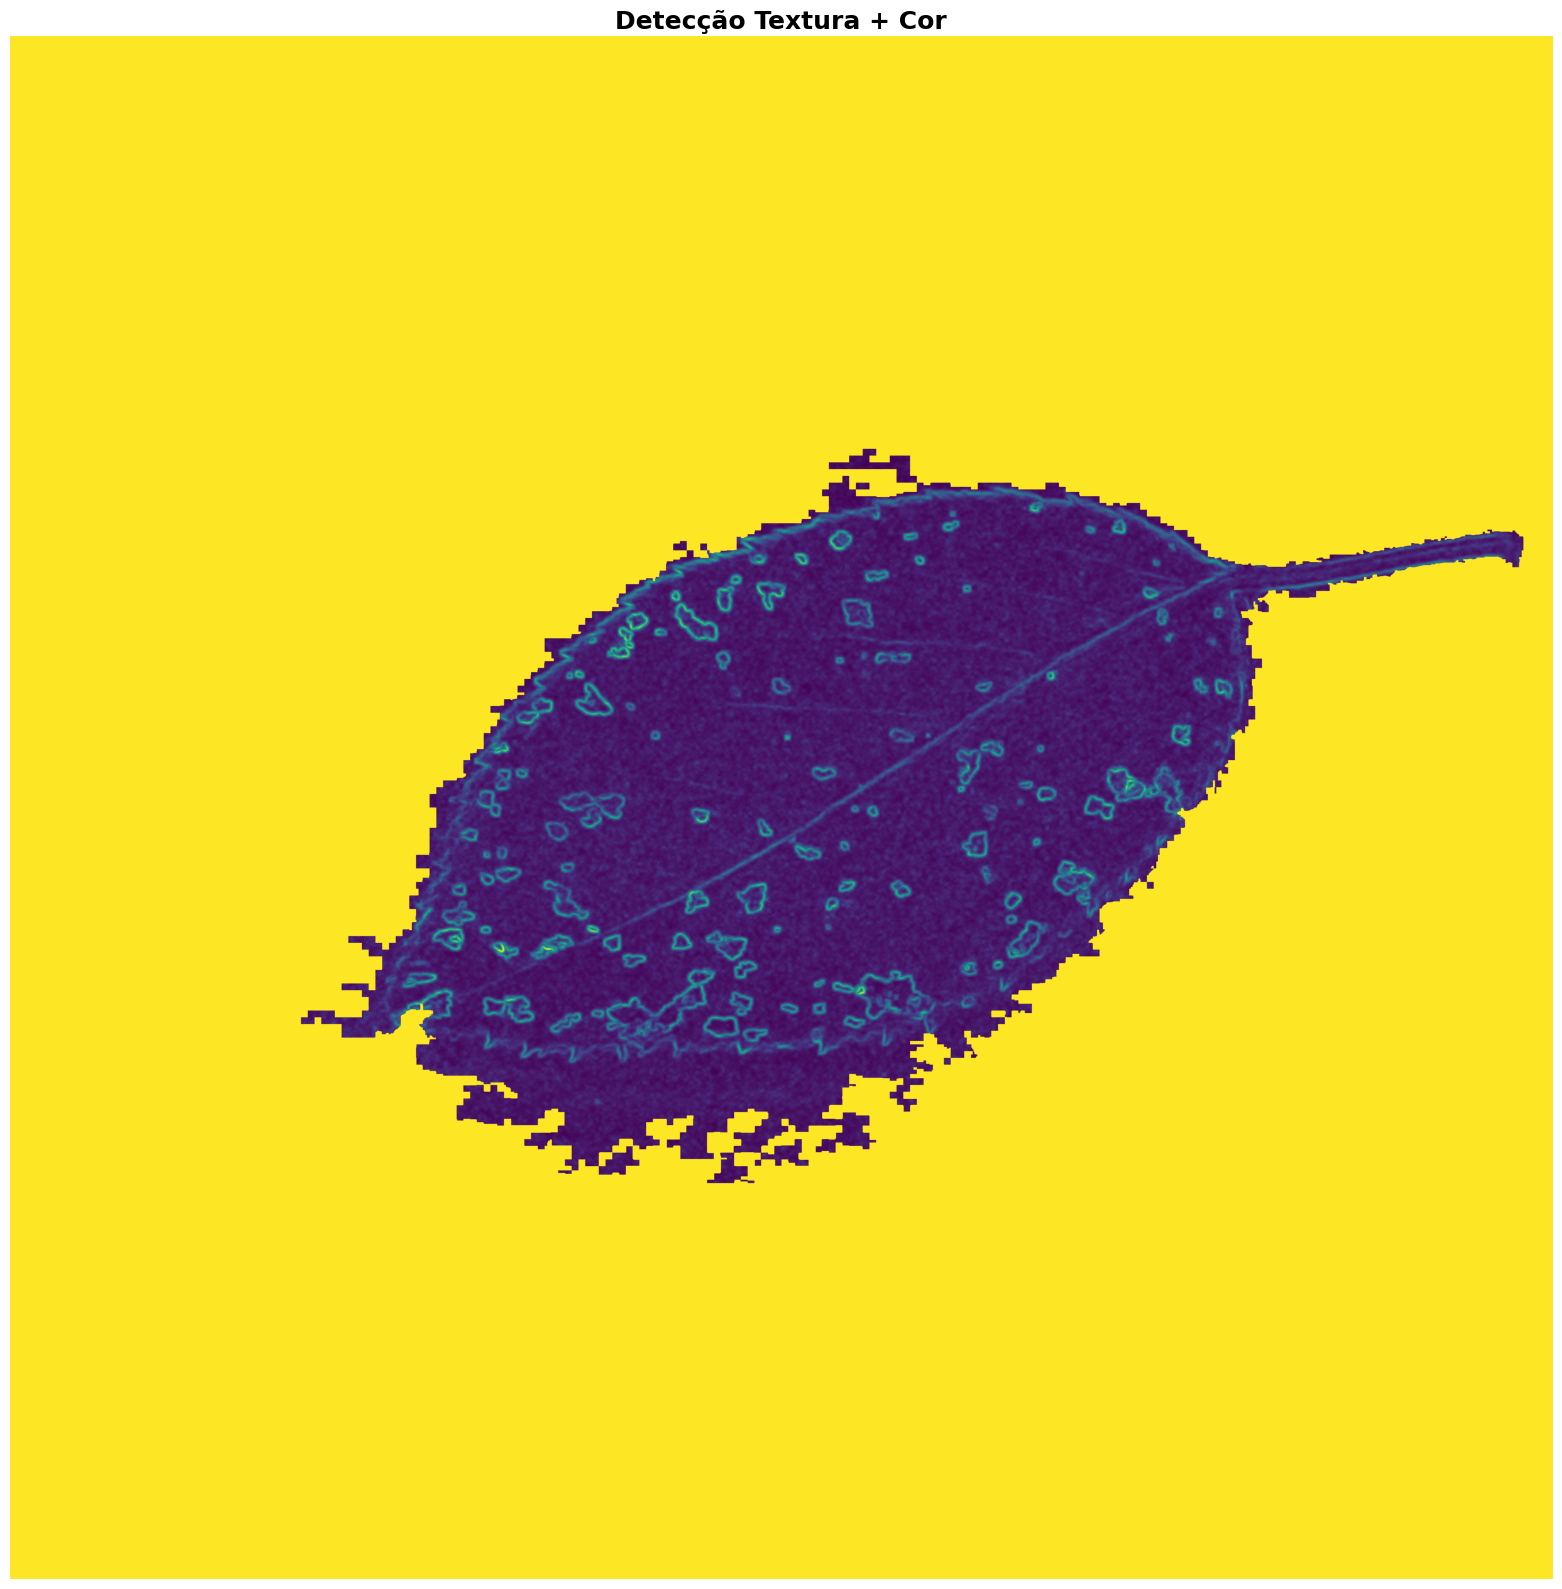

In [3]:
# ================= Main =================
if __name__ == "__main__":

    resultado = processar_textura_multiescala("folha.jpg")

    plt.figure(figsize=(16, 16))
    plt.imshow(resultado["img_resultado"])
    plt.title(
        f"Detecção Textura + Cor",
        fontsize=18,
        fontweight="bold"
    )
    plt.axis("off")
    plt.tight_layout()
    plt.imsave("textura.png", resultado["img_resultado"])
    print("\n💾 Imagem salva como: textura.png")
    plt.show()

PARTE 2

In [11]:
from scipy import ndimage as ndi
from matplotlib.patches import Circle

def erosao_binaria(imagem, elemento_estruturante):
    """Erosão binária manual"""
    altura, largura = imagem.shape
    eh, ew = elemento_estruturante.shape
    offset_h = eh // 2
    offset_w = ew // 2
    
    resultado = np.zeros_like(imagem, dtype=bool)
    
    for i in range(altura):
        for j in range(largura):
            if imagem[i, j]:  # Se pixel é 1
                # Verificar se todos os vizinhos definidos pelo elemento estruturante são 1
                encaixa = True
                for ei in range(eh):
                    for ej in range(ew):
                        if elemento_estruturante[ei, ej]:
                            ni = i + ei - offset_h
                            nj = j + ej - offset_w
                            
                            # Verificar bordas
                            if ni < 0 or ni >= altura or nj < 0 or nj >= largura:
                                encaixa = False
                                break
                            if not imagem[ni, nj]:
                                encaixa = False
                                break
                    if not encaixa:
                        break
                
                resultado[i, j] = encaixa
    
    return resultado


def dilatacao_binaria(imagem, elemento_estruturante):
    """Dilatação binária manual"""
    altura, largura = imagem.shape
    eh, ew = elemento_estruturante.shape
    offset_h = eh // 2
    offset_w = ew // 2
    
    resultado = np.zeros_like(imagem, dtype=bool)
    
    for i in range(altura):
        for j in range(largura):
            if imagem[i, j]:  # Se pixel é 1
                # Marcar todos os vizinhos definidos pelo elemento estruturante
                for ei in range(eh):
                    for ej in range(ew):
                        if elemento_estruturante[ei, ej]:
                            ni = i + ei - offset_h
                            nj = j + ej - offset_w
                            
                            # Verificar bordas
                            if 0 <= ni < altura and 0 <= nj < largura:
                                resultado[ni, nj] = True
    
    return resultado


def abertura_binaria(imagem, elemento_estruturante):
    """Abertura = Erosão seguida de Dilatação"""
    erodida = erosao_binaria(imagem, elemento_estruturante)
    aberta = dilatacao_binaria(erodida, elemento_estruturante)
    return aberta


def fechamento_binario(imagem, elemento_estruturante, iterations=1):
    """Fechamento = Dilatação seguida de Erosão"""
    resultado = imagem.copy()
    for _ in range(iterations):
        dilatada = dilatacao_binaria(resultado, elemento_estruturante)
        resultado = erosao_binaria(dilatada, elemento_estruturante)
    return resultado


def preencher_buracos(imagem):
    """Preenche buracos em regiões binárias usando flood fill"""
    altura, largura = imagem.shape
    preenchida = imagem.copy()
    visitado = np.zeros_like(imagem, dtype=bool)
    
    # Marcar o fundo (começando das bordas)
    def flood_fill(i, j):
        pilha = [(i, j)]
        while pilha:
            ci, cj = pilha.pop()
            if ci < 0 or ci >= altura or cj < 0 or cj >= largura:
                continue
            if visitado[ci, cj] or preenchida[ci, cj]:
                continue
            
            visitado[ci, cj] = True
            
            # 4-conectividade
            pilha.extend([(ci+1, cj), (ci-1, cj), (ci, cj+1), (ci, cj-1)])
    
    # Flood fill a partir de todas as bordas
    for i in range(altura):
        if not preenchida[i, 0]:
            flood_fill(i, 0)
        if not preenchida[i, largura-1]:
            flood_fill(i, largura-1)
    
    for j in range(largura):
        if not preenchida[0, j]:
            flood_fill(0, j)
        if not preenchida[altura-1, j]:
            flood_fill(altura-1, j)
    
    # Inverter: tudo que não foi visitado é buraco interno
    return preenchida | ~visitado

# ==============================================

def calcular_centro_massa_manual(regiao):
    """
    Calcula o centro de massa de uma região binária manualmente
    
    regiao: array booleano (True onde tem o fungo, False onde não tem)
    retorna: (cy, cx) - coordenadas do centro
    """
    # Pegar as coordenadas de TODOS os pixels que são True
    coordenadas_y, coordenadas_x = np.where(regiao)
    
    # Centro = média das coordenadas
    cx = np.mean(coordenadas_x)  # média dos X
    cy = np.mean(coordenadas_y)  # média dos Y
    
    return cy, cx

In [ ]:
def detectar_todos_fungos(caminho):
    # Carregar imagem
    img = io.imread(caminho)
    print(f"Imagem carregada: {img.shape}")
    
    # Converter RGBA para RGB se necessário
    if img.shape[-1] == 4:
        print("Convertendo RGBA para RGB...")
        img = img[..., :3]
    
    img_float = img.astype(np.float32) / 255.0
    
    R = img_float[..., 0]
    G = img_float[..., 1]
    B = img_float[..., 2]
    
    # ========== DETECTAR FUNDO AMARELO ==========
    fundo_amarelo = (R > 0.7) & (G > 0.7) & (B < 0.5)
    
    # ========== DETECTAR ÁREA DA FOLHA (roxo/azul do viridis) ==========
    # No viridis: roxo escuro, azul, verde, amarelo
    # Folha aparece em roxo/azul/verde (tudo exceto amarelo e preto)
    folha = (
        ((R > 0.1) | (G > 0.1) | (B > 0.1)) &  # Não é preto
        ~fundo_amarelo  # Não é amarelo
    )
    
    # Limpeza morfológica da folha
    folha_limpa = abertura_binaria(folha, np.ones((3, 3), dtype=bool))
    folha_limpa = fechamento_binario(folha_limpa, np.ones((5, 5), dtype=bool), iterations=1)
    folha_limpa = preencher_buracos(folha_limpa)
    
    # Pegar apenas a maior região (a folha principal)
    labeled_folha, num_folhas = ndi.label(folha_limpa)
    if num_folhas > 0:
        areas_folha = ndi.sum(folha_limpa, labeled_folha, range(1, num_folhas + 1))
        maior_folha = np.argmax(areas_folha) + 1
        folha_final = (labeled_folha == maior_folha)
    else:
        folha_final = folha_limpa
    
    area_folha = np.sum(folha_final)
  
    
    # ========== DETECTAR FUNGOS (cyan/verde-claro no viridis) ==========
    # Fungos aparecem em cyan/verde-água (alto G e B, médio/baixo R)
    fungos_cyan = (
        (G > 0.35) & 
        (B > 0.35) & 
        (B > R) & 
        (G > R * 0.9) &
        ~fundo_amarelo &
        folha_final  # IMPORTANTE: apenas dentro da folha
    )
    
    # Também detectar regiões verde-claro/cyan mais claras
    fungos_claro = (
        (G > 0.5) & 
        (B > 0.45) & 
        (G > R * 1.1) &
        ~fundo_amarelo &
        folha_final  # IMPORTANTE: apenas dentro da folha
    )
    
    # Combinar ambas detecções
    fungos_total = fungos_cyan | fungos_claro
    
    # Limpeza morfológica MÍNIMA para não perder fungos pequenos 
    fungos_limpo = abertura_binaria(fungos_total, np.ones((1, 1), dtype=bool))
    
    # Etiquetar regiões conectadas
    labeled, num_fungos = ndi.label(fungos_limpo)
    
    print(f"\n🔍 Regiões detectadas antes da filtragem: {num_fungos}")
    
    # Filtrar por área mínima
    areas = ndi.sum(fungos_limpo, labeled, range(1, num_fungos + 1))
    fungos_validos = []
    
    AREA_MINIMA = 15
    
    for i, area in enumerate(areas, 1):
        if area >= AREA_MINIMA:
            fungos_validos.append(i)
    
    print(f"✅ Fungos válidos (área >= {AREA_MINIMA} px): {len(fungos_validos)}")
    
    # Criar máscara final
    mascara_final = np.isin(labeled, fungos_validos)
    labeled_final, num_final = ndi.label(mascara_final)
    
    # ========== CALCULAR PORCENTAGEM ==========
    area_fungos = np.sum(mascara_final)
    porcentagem_infectada = (area_fungos / area_folha * 100) if area_folha > 0 else 0

    
    # Calcular informações de cada fungo
    fungos_info = []
    for i in range(1, num_final + 1):
        regiao = (labeled_final == i)
        cy, cx = calcular_centro_massa_manual(regiao)
        area = np.sum(regiao)
        raio = np.sqrt(area / np.pi) * 1.4
        
        fungos_info.append({
            'id': i,
            'centro': (cx, cy),
            'raio': raio,
            'area': area
        })
    
    # Ordenar por área (maiores primeiro)
    fungos_info.sort(key=lambda x: x['area'], reverse=True)
    
    # Renumerar
    for idx, info in enumerate(fungos_info, 1):
        info['id'] = idx
    
    
    # Estatísticas
    areas_list = [f['area'] for f in fungos_info]
    if areas_list:
        print(f"Área média: {np.mean(areas_list):.1f} px")
        print(f"Área mínima: {np.min(areas_list):.0f} px")
        print(f"Área máxima: {np.max(areas_list):.0f} px")
    
    # Visualizar - 3 plots em uma linha
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    # 1. IMAGEM ORIGINAL COM CÍRCULOS VERMELHOS
    axes[0].imshow(img)
    axes[0].set_title(
        f'Imagem Original\n{num_final} fungos detectados\n{porcentagem_infectada:.2f}% da folha infectada', 
        fontsize=18, fontweight='bold', color='red'
    )
    
    for info in fungos_info:
        circulo = Circle(info['centro'], info['raio'], 
                        color='red', fill=False, linewidth=2.5, alpha=0.8)
        axes[0].add_patch(circulo)
        
        # Numerar apenas os 20 maiores para não poluir
        if info['id'] <= 20:
            axes[0].text(info['centro'][0], info['centro'][1], 
                        str(info['id']), 
                        color='white', fontsize=10, fontweight='bold',
                        ha='center', va='center',
                        bbox=dict(boxstyle='circle', facecolor='red', 
                                 edgecolor='white', linewidth=1.5, alpha=0.9))
    
    axes[0].axis('off')
    
    # 2. MÁSCARA DE DETECÇÃO
    mascara_visual = np.zeros_like(img)
    verde = [0, 255, 0, 255] if img.shape[-1] == 4 else [0, 255, 0]
    mascara_visual[mascara_final] = verde
    mascara_visual[fundo_amarelo] = img[fundo_amarelo]
    
    axes[1].imshow(mascara_visual)
    axes[1].set_title(
        f'Regiões Detectadas (verde)\n{area_fungos:,} px de fungos', 
        fontsize=16, fontweight='bold'
    )
    axes[1].axis('off')
    
    # 3. HISTOGRAMA DE TAMANHOS
    if areas_list:
        axes[2].hist(areas_list, bins=30, color='teal', alpha=0.7, edgecolor='black')
        axes[2].set_xlabel('Área (pixels)', fontsize=14)
        axes[2].set_ylabel('Quantidade de fungos', fontsize=14)
        axes[2].set_title(
            f'Distribuição de Tamanhos\n{num_final} fungos | {porcentagem_infectada:.2f}% infectado', 
            fontsize=16, fontweight='bold'
        )
        axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return {
        'num_fungos': num_final,
        'fungos_info': fungos_info,
        'fig': fig,
        'areas': areas_list,
        'area_folha': area_folha,
        'area_fungos': area_fungos,
        'porcentagem': porcentagem_infectada
    }

Imagem carregada: (3648, 3648, 4)
Convertendo RGBA para RGB...

🔍 Regiões detectadas antes da filtragem: 357
✅ Fungos válidos (área >= 15 px): 277
Área média: 523.4 px
Área mínima: 15 px
Área máxima: 4726 px

🌿 ÁREA DA FOLHA: 2,325,740 pixels
🦠 ÁREA DE FUNGOS: 144,991 pixels
📊 PORCENTAGEM INFECTADA: 6.23%

💾 Salvo em: todos_fungos_detectados_tres_plots.png
📝 Posição dos fungos salva em: lista_fungos.txt


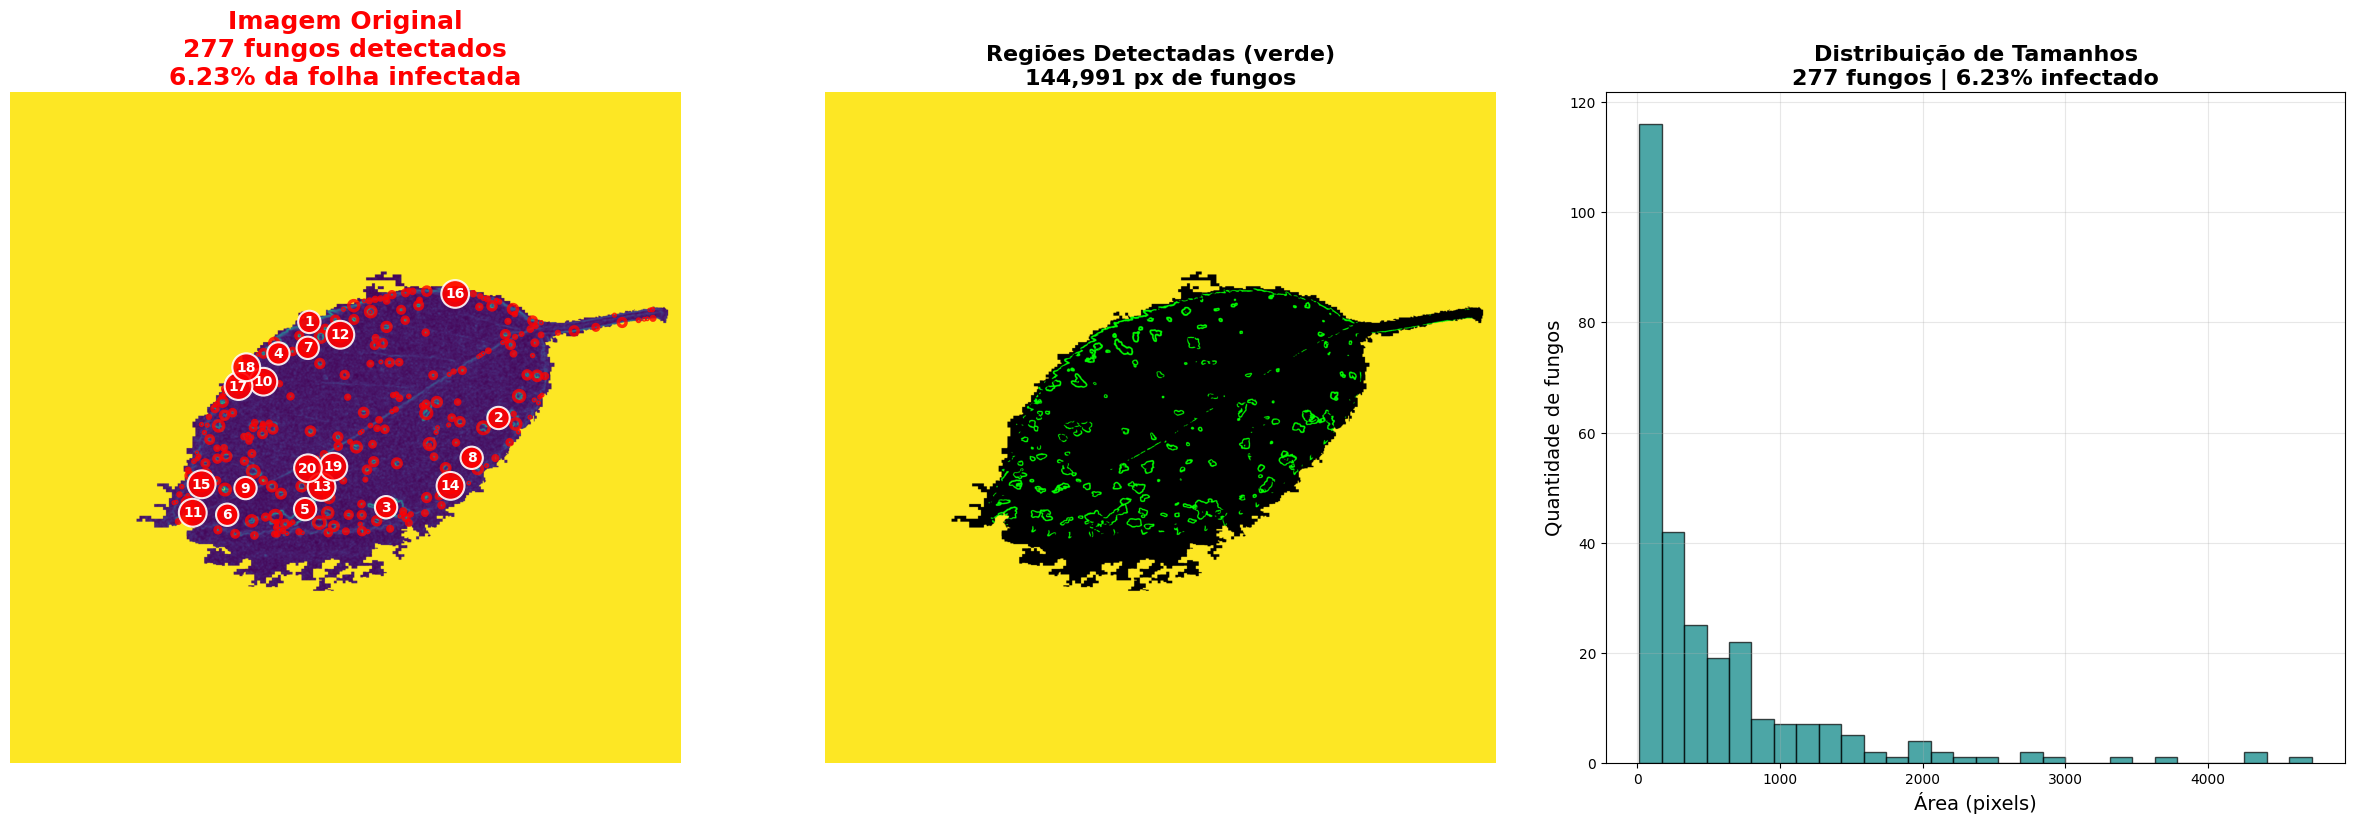

In [13]:
# ================= EXECUÇÃO =================
if __name__ == "__main__":
    resultado = detectar_todos_fungos("textura.png")
    
    print(f"\n{'='*60}")
    print(f"🌿 ÁREA DA FOLHA: {resultado['area_folha']:,} pixels")
    print(f"🦠 ÁREA DE FUNGOS: {resultado['area_fungos']:,} pixels")
    print(f"📊 PORCENTAGEM INFECTADA: {resultado['porcentagem']:.2f}%")
    print(f"{'='*60}")
    
    
    plt.savefig('todos_fungos_detectados_tres_plots.png', dpi=200, bbox_inches='tight')
    print(f"\n💾 Salvo em: todos_fungos_detectados_tres_plots.png")
    
    # Salvar lista completa em arquivo texto
    with open('lista_fungos.txt', 'w', encoding='utf-8') as f:
        f.write(f"DETECÇÃO DE FUNGOS - RESULTADO COMPLETO\n")
        f.write(f"{'='*60}\n\n")
        f.write(f"Total de fungos: {resultado['num_fungos']}\n")
        f.write(f"Área da folha: {resultado['area_folha']:,} pixels\n")
        f.write(f"Área de fungos: {resultado['area_fungos']:,} pixels\n")
        f.write(f"Porcentagem infectada: {resultado['porcentagem']:.2f}%\n\n")
        
        if resultado['areas']:
            f.write(f"Área média dos fungos: {np.mean(resultado['areas']):.1f} px\n")
            f.write(f"Área mínima: {np.min(resultado['areas']):.0f} px\n")
            f.write(f"Área máxima: {np.max(resultado['areas']):.0f} px\n\n")
        
        f.write(f"{'='*60}\n")
        f.write(f"LISTA COMPLETA (ordenada por tamanho):\n")
        f.write(f"{'='*60}\n\n")
        
        for info in resultado['fungos_info']:
            f.write(f"Fungo #{info['id']:3d}: posição ({info['centro'][0]:6.1f}, {info['centro'][1]:5.1f}) - {info['area']:5.0f} px²\n")
    
    print(f"📝 Posição dos fungos salva em: lista_fungos.txt")
    plt.show()